# torchsample - Tutorial

# `TensorDataset`
The `TensorDatset` provides a class structure for sampling from data that is already loaded into memory as torch tensors or numpy arrays.

## `TensorDataset` Explained

Here is the class signature for the `TensorDataset` class:
```python
class TensorDataset(Dataset):

    def __init__(self, 
                 input_tensor,
                 target_tensor=None,
                 transform=None, 
                 target_transform=None,
                 co_transform=None, 
                 batch_size=1,
                 shuffle=False,
                 sampler=None,
                 num_workers=0,
                 collate_fn=default_collate, 
                 pin_memory=False)
```

You can see the most obvious argument - `input_tensor`, which would be your input images/data. This can be of arbitrary size, but the first dimension should always be the number of samples and if the input represents an image then the channel dimension should be before the other dimensions (e.g. `(Channels, Height, Width)`).

There is also an <b>optional</b> target tensor, which might be a vector of integer classifications, continous values, or even another set of images or arbitrary data.

Next, there is the `transform`, which takes in the input tensor, performs some operation on it, and returns the modified version. The `target_transform` does the same thing with the `target_tensor`. 

There is also a `co_transform` argument to perform transforms on the `input_tensor` and `target_tensor` together. This is particularly useful for segmentation tasks, where we may want to perform the same affine transform on both the input image and the segmented image. Note that the `co_transform` will occur <b>after</b> the individual transforms.

There is a `batch_size` argument, which determines how many samples to take for each batch. There is also the boolean `shuffle` argument, which determines whether we will take samples sequentially as given or in a random order. 

Finally, there are a few arguments which relate to the multi-processing nature of the samping, which I wont get into but will refer interested readers to the official pytorch docs.

## `TensorDataset` Image -> Label Sampling

Having the input tensor be a collection of images and the target tensor be a vector of class labels is perhaps the most common scenario. We'll use this as the first demonstration and start by loading the mnist dataset from `torchvision`:



In [34]:
from torchvision.datasets import MNIST
train = MNIST(root='/users/ncullen/desktop/data/', train=True, download=True)
x_train = train.train_data
y_train = train.train_labels
test = MNIST(root='/users/ncullen/desktop/data/', train=False, download=True)
x_test = test.test_data
y_test = test.test_labels
print(x_train.size(), ' - ' , x_test.size())

torch.Size([60000, 28, 28])  -  torch.Size([10000, 28, 28])


Here we have a training set of 60k images of `28x28` size, and a testing st of 10k images of equal size, along with the digit labels for the images. 

We can look plot a few of these images:

DIGIT:  5


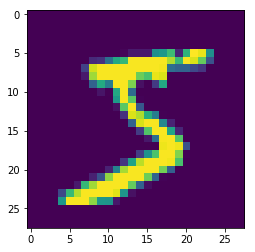

DIGIT:  0


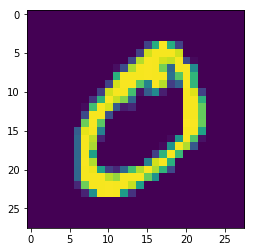

DIGIT:  4


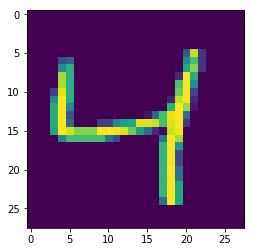

DIGIT:  1


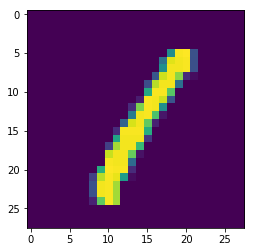

DIGIT:  9


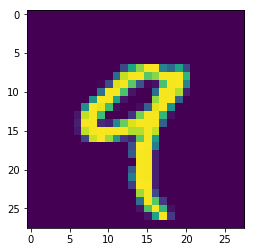

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(5):
    print('DIGIT: ', y_train[i])
    plt.imshow(x_train.numpy()[i])
    plt.show()

Now, we can create a `TensorDataset` for the training images. We wont have any transforms, but we will have a batch size of 3.


In [36]:
from torchsample import TensorDataset
train_data = TensorDataset(input_tensor=x_train, target_tensor=y_train,
                batch_size=3)

To get the first batch of 3 images and 3 labels, simply call `train_data.next()` or `next(train_data)`:


In [37]:
x_batch, y_batch = train_data.next()
print(x_batch.size(), ' - ' , y_batch.size())
print(x_batch.min() , ' - ' , x_batch.max())
print(x_batch.type())

torch.Size([3, 28, 28])  -  torch.Size([3])
0  -  255
torch.ByteTensor


To loop through the entire dataset one time, you can use the dataset just like an iterator:


In [38]:
i = 0
for x_batch, y_batch in train_data:
    print(x_batch.size())
    i+=1
    if i > 5:
        break # breaking so we dont loop through 60k images

torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])


We see that the images are still of size `28x28` and the tensors are still from range `0 - 255`, and the tensor is of type `ByteTensor`. Let's use three standard torch transforms -- `AddChannel()`, `RangeNormalize()`, and `TypeCast()` --  wrapped in a `Compose()` transform to change this:

In [39]:
from torchsample.transforms import TypeCast, AddChannel, RangeNormalize, Compose

tform = Compose([TypeCast('float'), AddChannel(), RangeNormalize(0,1)])
train_data = TensorDataset(x_train, y_train, transform=tform, batch_size=3)
x_batch, y_batch = train_data.next()
print(x_batch.size())
print(x_batch.min() , ' - ' , x_batch.max())
print(x_batch.type())

torch.Size([3, 1, 28, 28])
0.0  -  1.0
torch.FloatTensor



Very nice! Now let's add a simple augmentation transforms like `RandomFlip()`. 

`RandomFlip()` takes two booleans (whether to flip horizontal, and whether to flip vertical) and a probability with which to apply those flips.

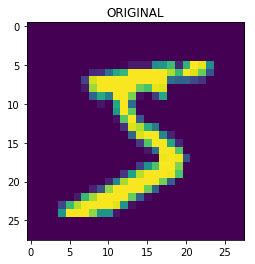

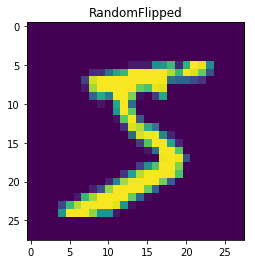

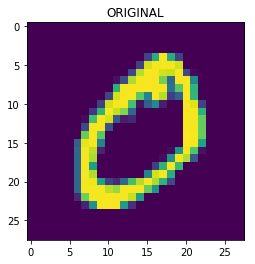

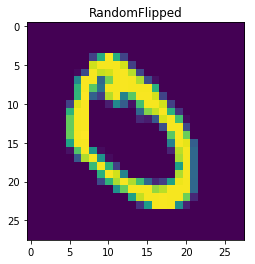

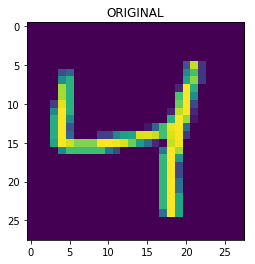

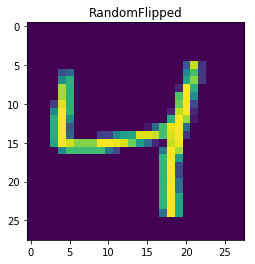

In [40]:
from torchsample.transforms import RandomFlip

process = Compose([TypeCast('float'), AddChannel(), RangeNormalize(0,1)])
augment = Compose([RandomFlip(h=True, v=False, p=0.5)])
tform = Compose([process, augment])

train_data = TensorDataset(x_train, y_train, transform=tform, batch_size=3)
x_batch, y_batch = next(train_data)

for i in range(3):
    plt.imshow(x_train.numpy()[i])
    plt.title('ORIGINAL')
    plt.show()
    plt.imshow(x_batch.numpy()[i][0])
    plt.title('RandomFlipped')
    plt.show()

Awesome! Now, let's take it one step further and apply some Affine transforms. We provide a few common affine transforms which can be individually used as transforms. For instance, let's randomly rotate the image using the `Rotate()` transform.


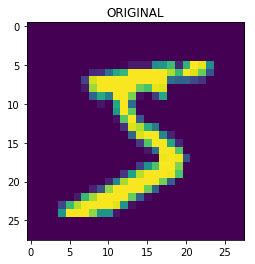

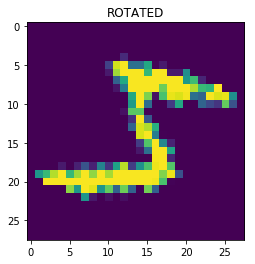

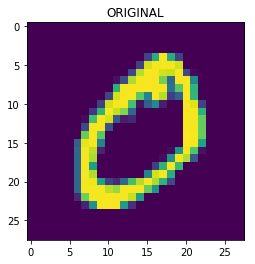

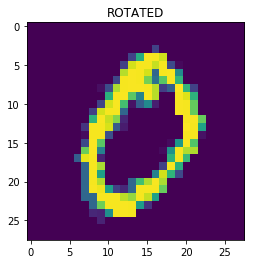

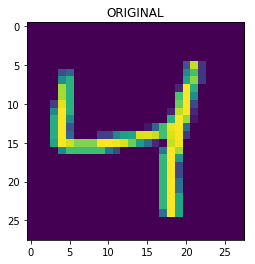

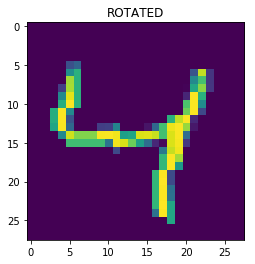

In [41]:
from torchsample.transforms import Rotate
process = Compose([TypeCast('float'), AddChannel(), RangeNormalize(0,1)])
augment = Rotate(30) # randomly rotate between (-30, 30) degrees
tform = Compose([process, augment])
train_data = TensorDataset(x_train, y_train, transform=tform, batch_size=3)
x_batch, y_batch = train_data.next()

for i in range(3):
    plt.imshow(x_train.numpy()[i])
    plt.title('ORIGINAL')
    plt.show()
    plt.imshow(x_batch.numpy()[i][0])
    plt.title('ROTATED')
    plt.show()

So cool! 

What if we wanted to string together multiple affine transforms? Well, affine transforms require interpolation, and having an interpolation for each affine transform might quickly cause the quality of the image details to distintegerate. For that reason, we provide an `AffineCompose()` transform which can compose multiple affine transforms together such that only one interpolation takes place. It does this by combining the transformation matrices of all the given transforms into a single matrix (without losing any info) before applying it.

Here, we will use both rotation and translation. The `Translate()` transform takes in a tuple `(x,y)` which provide lower and upper bounds, respectively, on the zoom in the image. `1.0` means no zoom, anything greater than `1.0` means zoom out, and less means zoom in.

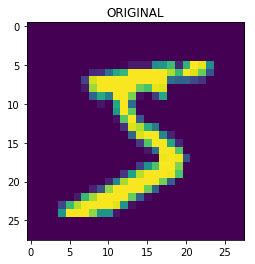

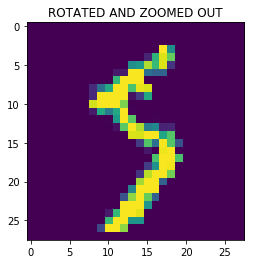

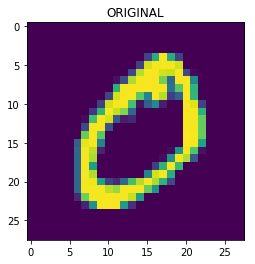

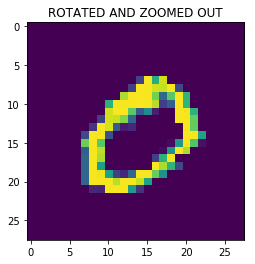

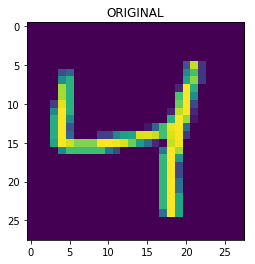

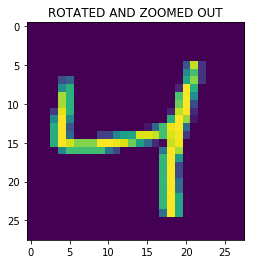

In [42]:
x_train = x_train.float() # convert data to float so we stop type casting each sample
x_train = x_train.view(60000,1,28,28) # add channel so we stop adding to each sample
from torchsample.transforms import Rotate, Zoom, AffineCompose
process = Compose([RangeNormalize(0,1)])
r_tform = Rotate(30) # randomly rotate between (-30, 30) degrees
z_tform = Zoom((1.0, 1.4)) # randomly zoom out btwn 100% and 140% of image size
affine_tform = AffineCompose([r_tform, z_tform]) # string affine tforms together
tform = Compose([process, affine_tform])
train_data = TensorDataset(x_train, y_train, transform=tform, batch_size=3)
x_batch, y_batch = train_data.next()

for i in range(3):
    plt.imshow(x_train.numpy()[i][0])
    plt.title('ORIGINAL')
    plt.show()
    plt.imshow(x_batch.numpy()[i][0])
    plt.title('ROTATED AND ZOOMED OUT')
    plt.show()

Amazing! 


However, having to create a separate transform for each affine variant is annoying. For that reason, we provide a single `Affine()` transform that takes as arguments the union of all the other individual affine transforms. This allows you to specify all of them in one place, while still preserving the one-interpolation rule:

    

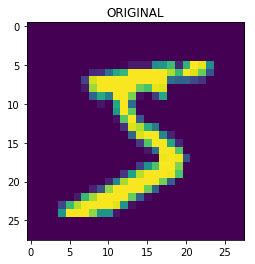

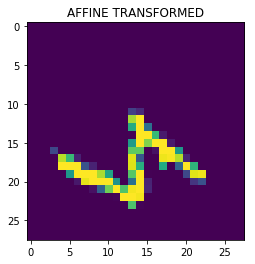

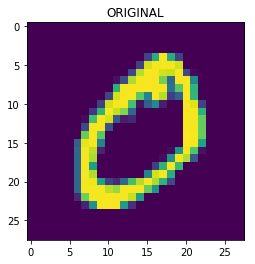

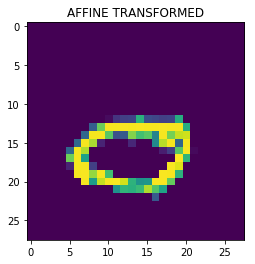

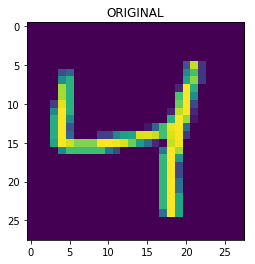

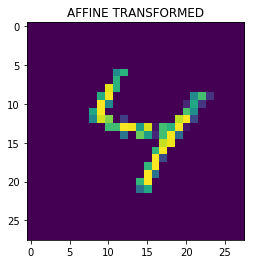

In [44]:
from torchsample.transforms import Affine
process = Compose([RangeNormalize(0,1)])
affine_tform = Affine(rotation_range=50, zoom_range=(1.3,1.5), shear_range=0.5,
    translation_range=(0.3,0.3))
tform = Compose([affine_tform])
train_data = TensorDataset(x_train, y_train, transform=tform, batch_size=3)
x_batch, y_batch = train_data.next()

for i in range(3):
    plt.imshow(x_train.numpy()[i][0])
    plt.title('ORIGINAL')
    plt.show()
    plt.imshow(x_batch.numpy()[i][0])
    plt.title('AFFINE TRANSFORMED')
    plt.show()


That was a good overview of the functionality of the `transforms` on torch tensors and the `TensorDataset` class for sampling from input and target tensors. 

## `TensorDataset` Image Sampling

I want to demonstrate another useful feature, which is sampling without any target tensor. This functionality can be nice if you just want to randomly transform some images to create an augmented dataset, but you don't want to do include a target tensor. Even more, we provide a `ToFile()` transform that will save all of the transformed images to file. This is good for inspecting what the sampling and augmentation is doing before actually using it. 

We provide the option to save to the following formats:
- `.npy` (numpy format - no intensity rescaling will take place)
- `.png` or `.jpg` (will automatically rescale intensity to 0 - 255)
    - not currently supported

In [19]:
from torchsample.transforms import ToFile
process = Compose([RangeNormalize(0,1)])
r_tform = Rotate(30) # randomly rotate between (-30, 30) degrees
z_tform = Zoom((1.0, 1.4)) # randomly zoom out btwn 100% and 140% of image size
affine_tform = AffineCompose([r_tform, z_tform]) # string affine tforms together
save = ToFile(root='/users/ncullen/desktop/transformed_images/', save_format='npy')
tform = Compose([process, affine_tform, save])
train_data = TensorDataset(x_train, transform=tform, batch_size=3)
x_batch = train_data.next()

saving
saving
saving


## `TensorDatset` Image -> Image Sampling

Finally, there is the case where your input tensor is a set of images, and your target tensor is also a set of images. In this case, you probably want to perform the same set of transforms on the target images as you do the input images. This is easy with the `TensorDataset` class.

Basically, all of the previous example transforms and augmentations are valid, but you should use the `co_transform` argument for any transforms that you want to apply to both input and target tensors.

Here's a simple demonstation with the `AffineCompose()` transform:


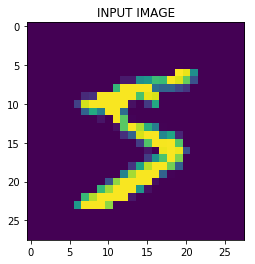

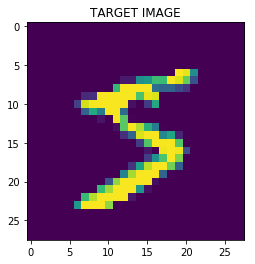

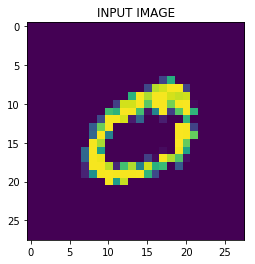

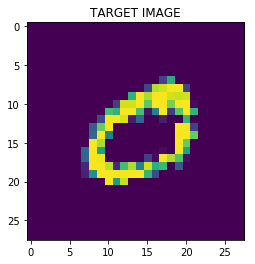

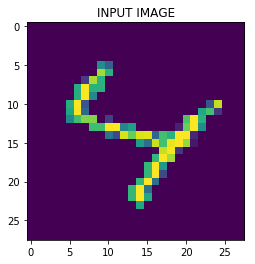

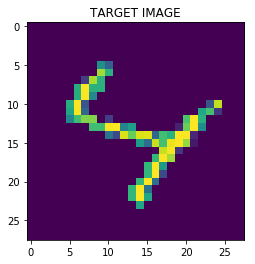

In [20]:
r_tform = Rotate(30) # randomly rotate between (-30, 30) degrees
z_tform = Zoom((1.0, 1.4)) # randomly zoom out btwn 100% and 140% of image size
affine_tform = AffineCompose([r_tform, z_tform]) # string affine tforms together
tform = Compose([process, affine_tform])
train_data = TensorDataset(x_train, x_train, co_transform=tform, batch_size=3)
x_batch, y_batch = train_data.next()

for i in range(3):
    plt.imshow(x_batch.numpy()[i][0])
    plt.title('INPUT IMAGE')
    plt.show()
    plt.imshow(y_batch.numpy()[i][0])
    plt.title('TARGET IMAGE')
    plt.show()

Sweet, the transforms applied to both images!

We can easily use separate transforms for both, but they should not be transforms that involve any randomness or the transform will not reliably apply to both input and target samples. Who knows, maybe this is something you want. Anyways, this is an example:

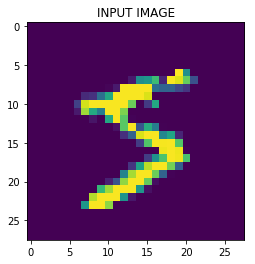

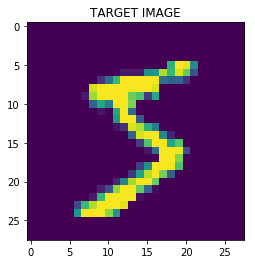

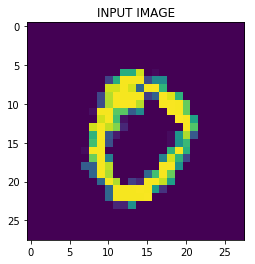

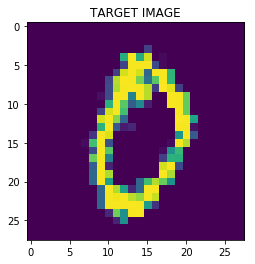

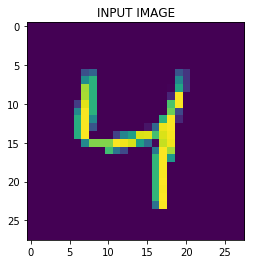

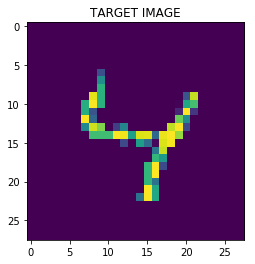

In [21]:
r_tform = Rotate(30) # randomly rotate between (-30, 30) degrees
z_tform = Zoom((1.0, 1.4)) # randomly zoom out btwn 100% and 140% of image size
affine_tform = AffineCompose([r_tform, z_tform]) # string affine tforms together
tform = Compose([process, affine_tform])
train_data = TensorDataset(x_train, x_train, transform=tform, 
                    target_transform=tform, batch_size=3)
x_batch, y_batch = train_data.next()

for i in range(3):
    plt.imshow(x_batch.numpy()[i][0])
    plt.title('INPUT IMAGE')
    plt.show()
    plt.imshow(y_batch.numpy()[i][0])
    plt.title('TARGET IMAGE')
    plt.show()

Now, you see the input and target images are <b>not</b> the same, because the randomness of the transforms did not carry over since we didn't specify them in the `co_transform` property.

That's all for `TensorDataset`, let's move onto the real gem: the `FolderDataset` class.


# `FolderDataset` class

## `FolderDataset` explained

The `FolderDataset` class is used for out-of-memory sampling of images or arbitrary data. The same features apply as found in the `TensorDataset` class and examples, but with an added step for actually loading the data into memory.

Let's look at the `TensorDataset` class signature. It may appear quite verbose, but it's really easy to pick up.


```python
class FolderDataset(Dataset):

    def __init__(self, 
                 root,
                 class_mode='label',
                 input_regex='*',
                 target_regex=None,
                 transform=None, 
                 target_transform=None,
                 co_transform=None, 
                 loader='npy',
                 batch_size=1,
                 shuffle=False,
                 sampler=None,
                 num_workers=0,
                 collate_fn=default_collate, 
                 pin_memory=False)
```

Here, we have the `root` argument, which is the path to the main directory holding the images. If using a classification dataset, the images should be arranged by class label as follows:

```
main_dir/
    class_1/   
        img1.jpg
        img2.jpg
        ...
        whatever_name_you_want.jpg
    class_2/
        img3.jpg
        ...
    ...
    class_n/
        whatever_name_you_want.jpg
        ...
```
Here, you would set `root=/path/to/main_dir/`. The above data structure and problem also corresponds to setting `class_mode='label'` in the class. This means that the target tensor is going to be the class label of the image.

If using a segmentation dataset or otherwise want another image (or arbitrary data) as the target tensor, we will set `class_mode='image'`. In this case, the images should be arranged in separate sub-directories for each pair of input image/data and target image/data. 

The folders can be named whatever you want, but the image names should share at least some common phrase to distinguish between the input and target data. That is because we use regular expressions to pick up which data is input and which data is target. 

```
main_dir/
    img1/
        my_img1.jpg
        my_segmentation1.jpg
    img2/
        my_img2.jpg
        my_segmentation2.jpg
    ...
    whatever_folder_name_you_want/
        my_img3.jpg
        my_segmentation3.jpg
```

For the above data structure and naming, we would set `input_regex='*img*'` and `target_regex='*segmentation*'`. This will ensure we pick up the right input and target tensors.

Finally, we have the `loader` argument, which determines how to load the data into memory. We provide two defaults: `loader='npy'` to load in numpy's `npy` files, and `loader='pil'` to load in images. 

You can also supply your own function for the `loader` argument to read arbitrary data formats. That function should take in a path as input, and output the loaded image. For instance, to load MRI brain images in the `nifti` format, you might do the following:

```python
import nibabel
def nifti_loader(path):
    return nibabel.load(path)
```

Finally, you can also simply set `class_mode=None`, in which case you will only have input tensors loaded into memory. Using this feature in combination with transforms is another good way to augment your data separately.

Using the `FolderDataset` class is otherwise the same as using the `TensorDataset` class, so I won't go into those details. 
